In [38]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
def extract_patch(img, x, y, p):
    return img[x : x + p, y : y + p]

In [3]:
def l1(p1, p2):
    return np.sum(abs(p1 - p2))

In [4]:
def l2(p1, p2):
    return np.sum((p1 - p2) ** 2) ** 0.5

In [6]:
def propagation(img, nnf_x, nnf_y, odd, p, loss_fn=l1):
    h, w = img.shape[0] - p, img.shape[1] - p
    if odd:
        for x in range(0, h-1):
            for y in range(0,w-1):
                best_d = nnf_x[x, y], nnf_y[x, y]
                best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y], y + nnf_y[x, y], p))
                if 0 <= x + nnf_x[x+1, y] < h and 0 <= y + nnf_y[x+1, y] < w and loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x+1, y], y + nnf_y[x+1, y], p)) < best_l:
                    best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x+1, y], y + nnf_y[x+1, y], p))
                    best_d = nnf_x[x+1, y], nnf_y[x+1, y]
                if 0 <= x + nnf_x[x, y+1] < h and 0 <= y + nnf_y[x, y+1] < w and loss_fn(extract_patch(img, x + best_d[0], y + best_d[1], p), extract_patch(img, x + nnf_x[x, y+1], y + nnf_y[x, y+1], p)) < best_l:
                    best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y+1], y + nnf_y[x, y+1], p))
                    best_d = nnf_x[x, y+1], nnf_y[x, y+1]
                nnf_x[x, y], nnf_y[x, y] = best_d
    else:
        for x in range(1, h):
            for y in range(1,w):
                best_d = nnf_x[x, y], nnf_y[x, y]
                best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y], y + nnf_y[x, y], p))
                if 0 <= x + nnf_x[x-1, y] < h and 0 <= y + nnf_y[x-1, y] < w and loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x-1, y], y + nnf_y[x-1, y], p)) < best_l:
                    best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x-1, y], y + nnf_y[x-1, y], p))
                    best_d = nnf_x[x-1, y], nnf_y[x-1, y]
                if 0 <= x + nnf_x[x, y-1] < h and 0 <= y + nnf_y[x, y-1] < w and loss_fn(extract_patch(img, x + best_d[0], y + best_d[1], p), extract_patch(img, x + nnf_x[x, y-1], y + nnf_y[x, y-1], p)) < best_l:
                    best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y-1], y + nnf_y[x, y-1], p))
                    best_d = nnf_x[x, y-1], nnf_y[x, y-1]
                nnf_x[x, y], nnf_y[x, y] = best_d
    return nnf_x, nnf_y
                                     
                                     
                                     
                                     
                                     

In [7]:
def random_search(img, nnf_x, nnf_y, p, L=5, loss_fn=l1):
    dir_random = [(-1,-1), (0,1), (1,0), (0,-1), (-1,0), (1,-1), (-1,1), (1,1)]
    h, w = img.shape[0] - p, img.shape[1] - p
    for x in range(h):
        for y in range(w):
            best_d = nnf_x[x, y], nnf_y[x, y]
            best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y], y + nnf_y[x, y], p))
            for i in range(L):
                dir_ = dir_random[np.random.randint(8)]
                while not(0 <= x + nnf_x[x ,y] + 2 ** i * dir_[0] < h) or not(0 <= y + nnf_y[x ,y] + 2 ** i * dir_[1] < w) or (nnf_x[x ,y] + 2 ** i * dir_[0] == 0 and nnf_y[x ,y] + 2 ** i * dir_[1]==0):
                    dir_ = dir_random[np.random.randint(8)]
                if loss_fn(extract_patch(img, x, y, p), extract_patch(img, int(x + nnf_x[x, y] + 2 ** i * dir_[0]), int(y + nnf_y[x, y] + 2 ** i * dir_[1]), p)) < best_l:
                    best_d = nnf_x[x ,y] + 2 ** i * dir_[0], nnf_y[x ,y] + 2 ** i * dir_[1]
            nnf_x[x, y], nnf_y[x, y] = best_d
    return nnf_x, nnf_y
                
            

In [17]:
def symetry_comparison(img, nnf_x, nnf_y, p, loss_fn=l1):
    h, w = img.shape[0] - p, img.shape[1] - p
    for x in range(h):
        for y in range(w):
            x_, y_ = x + nnf_x[x, y], y + nnf_y[x, y]
            best_l = loss_fn(extract_patch(img, x_, y_, p), extract_patch(img, x_ + nnf_x[x_, y_], y_ + nnf_y[x_, y_], p))
            if loss_fn(extract_patch(img, x_, y_, p), extract_patch(img, x, y, p)) < best_l:
                nnf_x[x_, y_] = - nnf_x[x, y]
                nnf_y[x_, y_] = - nnf_y[x, y]
    return nnf_x, nnf_y
            
            
            
            

In [9]:
def remove_0(nnf_x, nnf_y, p):
    for i in range(nnf_x.shape[0]):
        for j in range(nnf_x.shape[1]):
            while nnf_x[i,j] == nnf_y[i,j] == 0:
                nnf_x[i,j] = np.random.randint(-i, nnf_x.shape[0] - i - p)
    return nnf_x, nnf_y

In [57]:
def patchmatch(img, n_iters=100, p=8):
    h, w = img.shape[0] - p, img.shape[1] - p
    x = np.array(np.linspace(0,h-1,h))
    y = np.array(np.linspace(0,w-1,w))
    yy, xx = np.meshgrid(x, y)
    xx = xx.astype(int)
    yy = yy.astype(int)
    nnf_x = np.random.randint(-xx, h-xx-p)
    nnf_y = np.random.randint(-yy, w-yy-p)
    nnf_x, nnf_y = remove_0(nnf_x, nnf_y, p) # to avoid null move
    for i in tqdm(range(n_iters)):
        nnf_x, nnf_y = propagation(img, nnf_x, nnf_y, i%2, p)
        nnf_x, nnf_y = symetry_comparison(img, nnf_x, nnf_y, p)
        nnf_x, nnf_y = random_search(img, nnf_x, nnf_y, p)
    return nnf_x, nnf_y

In [58]:
img = np.random.randint(0,256, size=(40,40))
img[1:18, 4:23] = img[15:32, 20:39] 

In [70]:
nnf_x, nnf_y = patchmatch(img, 20, p=8)

100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


In [71]:
nnf_x[2:10, 4:12]

array([[14, 14, 14, 14, 14, 11, 14, 15],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14],
       [14, 14, 14, 14, 14, 14, 14, 14]])

In [72]:
nnf_y[2:10, 4:12]

array([[16, 16, 16, 16, 16,  4, 16,  9],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16]])

In [73]:
nnf_x[15:24, 20:31] 

array([[-14, -14, -14, -14, -14,  13, -14,  13, -14, -14,  12],
       [-14, -14, -14, -14, -14,  13, -14,   4, -14, -14,  11],
       [-14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14],
       [-14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14],
       [-14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14],
       [-14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14],
       [-14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14],
       [-14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14],
       [-14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14]])

In [74]:
nnf_y[15:24, 20:31]

array([[-16, -16, -16, -16, -16, -11, -16, -10, -16, -16, -24],
       [-16, -16, -16, -16, -16, -11, -16, -11, -16, -16, -24],
       [-16, -16, -16, -16, -16, -16, -16, -16, -16, -16, -16],
       [-16, -16, -16, -16, -16, -16, -16, -16, -16, -16, -16],
       [-16, -16, -16, -16, -16, -16, -16, -16, -16, -16, -16],
       [-16, -16, -16, -16, -16, -16, -16, -16, -16, -16, -16],
       [-16, -16, -16, -16, -16, -16, -16, -16, -16, -16, -16],
       [-16, -16, -16, -16, -16, -16, -16, -16, -16, -16, -16],
       [-16, -16, -16, -16, -16, -16, -16, -16, -16, -16, -16]])

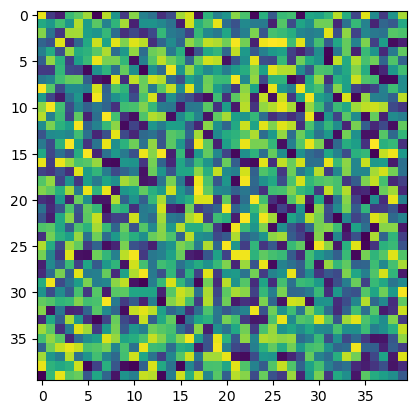

In [30]:
plt.imshow(img, interpolation='nearest')
plt.show()